In [1]:
from pathlib import Path
import pandas as pd
import pygwalker as pyg
import os
import csv
import shutil
from datetime import datetime, timedelta
import geodatasets
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns


g_curr_report_base = ''
g_report_dir = []

def list_directories(directory):
    path = Path(directory)
    directories = [p.name for p in path.iterdir() if p.name != 'combined']
    directories.sort()
    return directories


def read_all_report_dir(root):
    global g_report_dir
    g_report_dir.clear()
    bots = list_directories(root)
    for b in bots:
        entry = (b, [])
        g_report_dir.append(entry)
        b_dir = root + os.sep + b
        entry[1].extend(list_directories(b_dir))

    if len(g_report_dir) == 0:
        print('No report to analyze.')

def get_report_dir(bot, measurement):
    return f'{g_curr_report_base}/{bot}/{measurement}'


def get_measure_time(m):
    tr = m.split('_')
    s = datetime.strptime(tr[0], '%Y-%m-%d-%H-%M-%S')
    e = datetime.strptime(tr[1], '%Y-%m-%d-%H-%M-%S')
    return s, e

def get_bot_id_prefix(bot_dir):
    last_ = bot_dir.rfind("_")
    return bot_dir[last_ + 1:]


def cnc_stats_combine_same_ip(df):
    def custom_agg(group):
        start_time_min = group['start_time'].min()
        end_time_max = group['end_time'].max()
        attemp_start_min = group['attemp_start'].min()
        return pd.Series({
            'bot_id': group['bot_id'].unique()[0],
            'measure_start': group['measure_start'].unique()[0],
            'measure_end': group['measure_end'].unique()[0],
            'port': ','.join(group['port'].astype(str))[:256],
            'packet_cnt': group['packet_cnt'].sum(),
            'total_bytes': group['total_bytes'].sum(),
            'syn_cnt': group['syn_cnt'].sum(),
            'fin_cnt': group['fin_cnt'].sum(),
            'rst_cnt': group['rst_cnt'].sum(),
            'start_time': start_time_min,
            'end_time': end_time_max,
            'attemp_start': attemp_start_min,
            'duration': end_time_max - start_time_min
        })

    grouped = df.groupby('ip')
    result = grouped.apply(custom_agg, include_groups=False).reset_index()
    result = result[['ip'] + [col for col in result.columns if col != 'ip']]
    return result


def combine_all_measurements(bot, measurements):
    combined_dir = f'{g_curr_report_base}/{bot}/combined'

    if not os.path.exists(combined_dir):
        os.makedirs(combined_dir)

    f0 = f'{g_curr_report_base}/{bot}/combined/measurements.csv'
    f1 = f'{g_curr_report_base}/{bot}/combined/cnc-status.csv'
    f2 = f'{g_curr_report_base}/{bot}/combined/cnc-stats.csv'
    f3 = f'{g_curr_report_base}/{bot}/combined/attacks.csv'
    f4 = f'{g_curr_report_base}/{bot}/combined/error.csv'
    bid = get_bot_id_prefix(bot)
    m_list = []
    df1 = []
    df2 = []
    df3 = []
    df4 = []

    # filter out measurement from 2024-06-29 when tool support multiple CnCs
    filter_date = datetime(2024, 6, 29, 00, 00, 00)

    for m in measurements:
        base = get_report_dir(bot, m)
        ms, me = get_measure_time(m)
        cnc_ips = []
        m_dict = {}
        m_dict['bot_id'] = bid
        m_dict['measure_start'] = ms
        m_dict['measure_end'] = me
        
        #if ms > filter_date:
        #    print(f'measurement of {ms}~{me} filtered out!')
        #    continue
        
        duration = me - ms
        m_dict['duration'] = 1.0 * duration.total_seconds() / 3600
        m_list.append(m_dict)
        f = f'{base}/cnc-status.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            #cnc_ips = d['cnc_ip'].unique()
            cnc_ips = d['ip'].unique()
            d['measure_start'] = ms
            d['measure_end'] = me
            d['bot_id'] = bid
            df1.append(d)
        f = f'{base}/cnc-stats.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            d['measure_start'] = ms
            d['measure_end'] = me
            d['bot_id'] = bid
            d['start_time'] = pd.to_datetime(d['start_time'])
            if 'duration' not in d.columns:
                d['end_time'] = pd.to_datetime(d['end_time'])
                d['duration'] = d['end_time'] - d['start_time']
            d['duration'] =  pd.to_timedelta(d['duration'])
            if 'end_time' not in d.columns:
                d['end_time'] =  d['start_time'] + d['duration']
            d['duration'] =  d['duration'].dt.total_seconds()
            d['attemp_start'] = d['start_time'] - d['measure_start']
            d['is_cnc'] =  d['ip'].isin(cnc_ips)

            #filter out syn_cnt < 2 which could be scans
            d = d[~(d['syn_cnt'] < 2)]
            
            # combine records with same IP, we only care Cnc IPs, not port
            #d1 = cnc_stats_combine_same_ip(d)
            df2.append(d)
        f = f'{base}/attacks.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            d['measure_start'] = ms
            d['measure_end'] = me
            if 'bot_id' not in d.columns:
                d['bot_id'] = bid
            d['duration'] =  pd.to_timedelta(d['duration'])
            #d['duration'] =  d['duration'].dt.total_seconds()
            df3.append(d)
        f = f'{base}/error.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            d['measure_start'] = ms
            d['measure_end'] = me
            df4.append(d)
        else:
            pass
            #print(f'bot_id {bid}: {m} has no error report!')

    if len(m_list) > 0:
        df_m = pd.DataFrame(m_list, columns=['bot_id', 'measure_start', 'measure_end', 'duration'])
        df_m.to_csv(f0, index=False)
    if len(df1) > 0:
        pd.concat(df1, ignore_index=True).to_csv(f1, index=False)
    if len(df2) > 0:
        pd.concat(df2, ignore_index=True).to_csv(f2, index=False)
    if len(df3) > 0:
        pd.concat(df3, ignore_index=True).to_csv(f3, index=False)
    if len(df4) > 0:
        pd.concat(df4, ignore_index=True).to_csv(f4, index=False)

    return "combined"


def combine_all_reports(bots):
    combined_dir = f'{g_curr_report_base}/combined'
    if not os.path.exists(combined_dir):
        os.makedirs(combined_dir)

    f0 = f'{g_curr_report_base}/combined/measurements.csv'
    f1 = f'{g_curr_report_base}/combined/cnc-status.csv'
    f2 = f'{g_curr_report_base}/combined/cnc-stats.csv'
    f3 = f'{g_curr_report_base}/combined/attacks.csv'
    f4 = f'{g_curr_report_base}/combined/error.csv'
    df0 = []
    df1 = []
    df2 = []
    df3 = []
    df4 = []
    for b, ms in bots:
        if b == '2024_06_12_06_37_05_mirai_c087ad31':
            print(f'skip {b}')
            continue
        combine_all_measurements(b, ms)

    for b, _ in bots:
        base = f'{g_curr_report_base}/{b}/combined'
        f = f'{base}/measurements.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            df0.append(d)
        f = f'{base}/cnc-status.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            df1.append(d)
        f = f'{base}/cnc-stats.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            df2.append(d)
        f = f'{base}/attacks.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            df3.append(d)
        f = f'{base}/error.csv'
        if os.path.isfile(f):
            d = pd.read_csv(f)
            df4.append(d)

    if len(df0) > 0:
        pd.concat(df0, ignore_index=True).to_csv(f0, index=False)
    if len(df1) > 0:
        pd.concat(df1, ignore_index=True).to_csv(f1, index=False)
    if len(df2) > 0:
        pd.concat(df2, ignore_index=True).to_csv(f2, index=False)
    if len(df3) > 0:
        pd.concat(df3, ignore_index=True).to_csv(f3, index=False)
    if len(df4) > 0:
        pd.concat(df4, ignore_index=True).to_csv(f4, index=False)

    return "combined"

def input_report_base_menu():
    global g_curr_report_base
    print('\nChoose report base directory:, 1. ERROR, 2. UNSTAGED, 3. WORKING')
    op = input()
    if op == '1':
        g_curr_report_base = 'report-v2/error'
    elif op == '2':
        g_curr_report_base = 'report-v2/unstaged'
    elif op == '3':
        g_curr_report_base = 'repoort-v2'
    else:
        pass

def input_measurement_menu():
    if len(g_report_dir) == 0:
        return
    print('\nChoose bot, 0 for combined report for all bots:')
    i = 1
    for b in g_report_dir:
        print(f'    {i}. {b[0]}')
        i += 1
    b_idx = int(input())
    if b_idx == 0:
        m_dir = combine_all_reports(g_report_dir)
        return f'{g_curr_report_base}/{m_dir}'

    print('\nChoose measurement, 0 for combined report for all measurements:')
    i = 1
    bot = g_report_dir[b_idx - 1]
    for m in bot[1]:
        print(f'    {i}. {m}')
        i += 1
    m_idx = int(input())
    if m_idx == 0:
        m_dir = combine_all_measurements(bot[0], bot[1])
    else:
        m_dir = bot[1][m_idx - 1]
        
    return f'{g_curr_report_base}/{bot[0]}/{m_dir}'

In [146]:
# start
input_report_base_menu()
read_all_report_dir(g_curr_report_base)


Choose report base directory:, 1. ERROR, 2. UNSTAGED, 3. WORKING


 1


In [147]:
base = input_measurement_menu()


Choose bot, 0 for combined report for all bots:
    1. 2024_06_27_01_32_01_mirai_032df285
    2. 2024_06_27_01_32_05_mirai_2c8cddd3
    3. 2024_06_27_01_32_08_mirai_da179823
    4. 2024_06_27_01_32_14_mirai_cf4da168
    5. 2024_06_27_18_57_50_mirai_f125f9e4
    6. 2024_06_27_18_58_00_mirai_75bea82a
    7. 2024_06_27_18_58_09_mirai_2e2b1fc0
    8. 2024_06_27_18_58_18_mirai_3aed1897
    9. 2024_06_27_18_58_27_mirai_d8defbc1
    10. 2024_06_27_19_43_18_mirai_d5520eb1
    11. 2024_06_27_19_49_11_mirai_f2f93fb8
    12. 2024_06_27_19_50_56_mirai_c89da28d
    13. 2024_06_27_19_51_10_mirai_fa4df900
    14. 2024_06_28_06_46_23_mirai_4cd3c258
    15. 2024_06_28_06_46_36_mirai_501d1138
    16. 2024_06_28_06_46_56_mirai_4bb07698
    17. 2024_06_28_06_47_09_mirai_1416e5d0
    18. 2024_06_28_10_52_29_mirai_59a36fbf
    19. 2024_06_28_13_13_23_mirai_d79eb20a
    20. 2024_06_28_13_13_32_mirai_a5ca7d0c
    21. 2024_06_28_13_13_41_mirai_cac8cd0f
    22. 2024_06_28_13_59_39_mirai_0d0defbf
    23. 2024_0

 0


In [144]:
f = f'{base}/measurements.csv'
if os.path.isfile(f):
    df = pd.read_csv(f)
    walker = pyg.walk(df, kernel_computation=True)
else:
    print('file not exist!')

Box(children=(HTML(value='\n<div id="ifr-pyg-00061f207575af90Ts2nbVIRlWGHayEz" style="height: auto">\n    <hea…

In [94]:
f = f'{base}/cnc-status.csv'
if os.path.isfile(f):
    df = pd.read_csv(f)
    walker = pyg.walk(df, kernel_computation=True)
else:
    print('file not exist!')

Box(children=(HTML(value='\n<div id="ifr-pyg-00061f0f01e4b8cfCXZdihWuJOY72Vy5" style="height: auto">\n    <hea…

In [95]:
f = f'{base}/cnc-stats.csv'
if os.path.isfile(f):
    df = pd.read_csv(f)
    walker = pyg.walk(df, kernel_computation=True)
else:
    print('file not exist!')

Box(children=(HTML(value='\n<div id="ifr-pyg-00061f0f03cfcbdbNZGCXKbDHMjmu7iw" style="height: auto">\n    <hea…

In [96]:
f = f'{base}/attacks.csv'
if os.path.isfile(f):
    df = pd.read_csv(f)
    walker = pyg.walk(df, kernel_computation=True)
else:
    print('file not exist!')

Box(children=(HTML(value='\n<div id="ifr-pyg-00061f0f056afeed3kXszAtTRLyFSMJc" style="height: auto">\n    <hea…

In [129]:
f = f'{base}/error.csv'
if os.path.isfile(f):
    df = pd.read_csv(f)
    walker = pyg.walk(df, kernel_computation=True)
else:
    print('file not exist!')

Box(children=(HTML(value='\n<div id="ifr-pyg-00061f1f41fa9a92easfkKCHjXIgTOcE" style="height: auto">\n    <hea…

In [97]:
# filter live C2 from attack info
base='report-v1/unstaged/combined'
ar = f'{base}/attacks.csv'
df = pd.read_csv(ar)

#print(df.head())
df_lc = df[['cnc_ip','cnc_port']].drop_duplicates()
df_lc.rename(columns={'cnc_ip': 'ip'}, inplace=True)
df_lc.rename(columns={'cnc_port': 'port'}, inplace=True)
df_lc.to_csv(f'{base}/live_cnc.csv',index=False)


In [109]:
# any C2 which might not attack?
base='report-v1/unstaged/combined'
cnc_db = pd.read_csv(f'{base}/cnc_info.csv')
cnc_st = pd.read_csv(f'{base}/cnc-stats.csv')
live_cnc = pd.read_csv(f'{base}/live_cnc.csv')[['ip']]

cnc_filtered = pd.merge(cnc_db, live_cnc, on=['ip'], how='inner')
cnc_filtered.to_csv(f'{base}/cnc_info_live.csv',index=False)
cnc_ip_port = cnc_filtered[['ip','port']]

#cnc_filtered['port'] = cnc_filtered['port'].astype(str)
cnc_st_filtered = pd.merge(cnc_st, cnc_ip_port, on=['ip', 'port'], how='inner')
cnc_st_filtered = cnc_st_filtered[(cnc_st_filtered['is_cnc']==True) & (cnc_st_filtered['total_bytes']>0) & (cnc_st_filtered['is_new']=='no')]
cnc_st_filtered = cnc_st_filtered.drop_duplicates()
cnc_st_db = cnc_st_filtered[['ip','port','measure_start','measure_end','bot_id']]
cnc_st_db.to_csv(f'{base}/cnc_stats_db.csv',index=False)

walker = pyg.walk(cnc_st_db, kernel_computation=True)



Box(children=(HTML(value='\n<div id="ifr-pyg-00061f0fa6410be1cOiBwGSNQ02y8pWR" style="height: auto">\n    <hea…

In [90]:
# process data for 2024_06_12_06_37_05_mirai_c087ad31 which is re-analyzed
base='report-v1/unstaged/2024_06_12_06_37_05_mirai_c087ad31/combined_good'
df = pd.read_csv(f'{base}/cnc-status.csv')
df.rename(columns={'ip': 'cnc_ip','port': 'cnc_port','update_time': 'cnc_update_at','status': 'cnc_status','domain':'cnc_ready'}, inplace=True)
df['cnc_ready'] = True
#print(df.head())
df.to_csv(f'{base}/cnc-status-align.csv')

df1 = pd.read_csv(f'{base}/attacks.csv')
df1.drop(columns=['layers'], inplace=True)
#print(df1.head())
df1.to_csv(f'{base}/attacks-align.csv')

df2 = pd.read_csv(f'{base}/cnc-stats.csv')
df2['is_new'] = 'no'
#print(df2.head())
df2.to_csv(f'{base}/cnc-stats-align.csv')


           cnc_ip  cnc_port    cnc_status               cnc_update_at  \
0  142.250.74.228       443     candidate  2024-06-17 13:31:30.586492   
1  142.250.74.228       443         alive  2024-06-17 13:40:27.537836   
2  142.250.74.228       443  disconnected  2024-06-17 13:40:36.142203   
3  142.250.74.228       443         alive  2024-06-17 13:40:43.533331   
4  142.250.74.228       443  disconnected  2024-06-17 13:40:44.132622   

   cnc_ready        measure_start          measure_end    bot_id  
0       True  2024-06-17 12:23:23  2024-06-17 15:53:42  c087ad31  
1       True  2024-06-17 12:23:23  2024-06-17 15:53:42  c087ad31  
2       True  2024-06-17 12:23:23  2024-06-17 15:53:42  c087ad31  
3       True  2024-06-17 12:23:23  2024-06-17 15:53:42  c087ad31  
4       True  2024-06-17 12:23:23  2024-06-17 15:53:42  c087ad31  
  attack_type                  start_time      duration              src  \
0    Scanning  2024-06-17 11:55:47.695394   1573.041944   192.168.122.17   
1   DP 

In [172]:
# combine rebuilt cnc-status for v1
base='report-v1/unstaged/combined'
ss = []
ss.append(pd.read_csv(f'{base}/cnc_status_rebuilt_1_20.csv'))
ss.append(pd.read_csv(f'{base}/cnc_status_rebuilt_21_40.csv'))
ss.append(pd.read_csv(f'{base}/cnc_status_rebuilt_41_60.csv'))
ss.append(pd.read_csv(f'{base}/cnc_status_rebuilt_61_80.csv'))
ss.append(pd.read_csv(f'{base}/cnc_status_rebuilt_81_108.csv'))

c2status = pd.concat(ss, ignore_index=True)
c2status.rename(columns={'bot_id':'ip1','ip':'port1','port':'bot_id'}, inplace=True)
c2status.rename(columns={'ip1':'ip','port1':'port'}, inplace=True)
print(c2status.head())
c2status.to_csv(f'{base}/cnc-status-rebuilt.csv')

#walker = pyg.walk(c2status, kernel_computation=True)


             ip   port    bot_id        measure_start          measure_end  \
0  94.156.10.24  33335  114187eb  2024-06-17 10:34:47  2024-06-17 10:48:03   
1  94.156.10.24  33335  114187eb  2024-06-17 12:23:16  2024-06-17 12:45:26   
2  94.156.10.24  33335  114187eb  2024-06-17 12:52:26  2024-06-17 15:53:43   
3  94.156.10.24  33335  114187eb  2024-06-18 09:54:46  2024-06-18 12:53:21   
4  94.156.10.24  33335  114187eb  2024-06-18 15:31:39  2024-06-18 15:42:05   

  status                 update_time  
0  alive  2024-06-17 10:39:56.425674  
1  alive  2024-06-17 12:28:29.593738  
2  alive  2024-06-17 12:57:28.517642  
3  alive  2024-06-18 09:59:49.485185  
4  alive  2024-06-18 15:32:08.453729  


In [125]:
# aligh attacks to attack_info.csv
base='report-v1/unstaged/combined'

attacks = pd.read_csv(f'{base}/attacks.csv')

attacks = attacks[(attacks['target']!='192.168.122.1') & (attacks['target']!='192.168.122.0/24')]
attacks.rename(columns={'start_time':'time','packet_cnt':'packet_num'}, inplace=True)
attacks.drop(columns=['measure_start','measure_end','Unnamed: 0'], inplace=True)
attacks['pps'] = attacks['packet_num'] / attacks['duration']
attacks['bandwidth'] = attacks['total_bytes'] / attacks['duration']
attacks['duration'] = pd.to_timedelta(attacks['duration'], unit='s')
print(attacks.head())
attacks.to_csv(f'{base}/attack_info.csv')

   attack_type                        time               duration  src  \
6    DP Attack  2024-06-17 10:44:44.630238 0 days 00:00:59.999858  NaN   
7    DP Attack  2024-06-17 12:34:10.612168 0 days 00:00:59.989574  NaN   
8    DP Attack  2024-06-17 12:38:20.697047 0 days 00:00:47.090784  NaN   
9    DP Attack  2024-06-17 14:02:36.555025 0 days 00:07:16.000404  NaN   
10   DP Attack  2024-06-17 13:02:25.541782 0 days 00:00:59.988264  NaN   

             target protocol  src_port dst_port spoofed  packet_num  \
6   195.181.175.131      dns       NaN      NaN      no        3690   
7   195.181.175.131      dns       NaN      NaN      no        2940   
8    136.244.117.37      udp       NaN      NaN      no        2622   
9    135.148.25.152  udp,tcp       NaN      NaN      no        2718   
10    212.78.83.160      udp       NaN      NaN      no        3870   

    total_bytes                                             bot_id  \
6       3890827  114187eba041719065c8ebd1f441b959077f28ff6

In [134]:
# combine enriched attack info for v1
base='report-v1/unstaged/combined/V1_READY'
attacks = []
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_1_140.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_141_280.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_281_420.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_421_560.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_561_700.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_701_840.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_841_980.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_981_1028.csv'))

attacks_enriched = pd.concat(attacks, ignore_index=True)
attacks_enriched.to_csv(f'{base}/attack_info_enriched.csv')

walker = pyg.walk(attacks_enriched, kernel_computation=True)

Box(children=(HTML(value='\n<div id="ifr-pyg-00061f1f6e0323e9YS9h3yqMBen7ZtfK" style="height: auto">\n    <hea…

In [150]:
# combine enriched attack info for v2
base='backup/report/V2/DB'
attacks = []
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_1_874.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_875_875.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_876_1326.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_1327_1777.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_1778_2333.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_2334_2794.csv'))
attacks.append(pd.read_csv(f'{base}/attack_info_enriched_2975_3153.csv'))

attacks_enriched = pd.concat(attacks, ignore_index=True)
attacks_enriched.to_csv(f'{base}/attack_info_enriched.csv')

walker = pyg.walk(attacks_enriched, kernel_computation=True)

Box(children=(HTML(value='\n<div id="ifr-pyg-00061f20b8e967e8wU8Q9xMmKS2VWhBr" style="height: auto">\n    <hea…

In [767]:
# combined all data from V1 and V2
base1='extracted/V1'
base2='extracted/V2'
target='extracted/combined'

attacks = pd.read_csv(f'{target}/attack_info_enriched.csv')
print(f'--->{len(attacks)}')
attacks = attacks[~((attacks['attack_type'] != 'Scanning') & (attacks['pps'] == 0))]
print(f'--->{len(attacks)}')
attacks.to_csv(f'{target}/attack_info_enriched.csv')


#db1 = pd.read_csv(f'{base1}/measurements/combined/activated/measurements.csv')
#db1.drop(columns=['Unnamed: 0'], inplace=True)
#db1['version'] = 'v1'
#print(db1.head())
#db2 = pd.read_csv(f'{base2}/measurements/combined/activated/measurements.csv')
#db2.drop(columns=['domain'], inplace=True)
#db2['port'] = db2['port'].astype(str)
#db2['version'] = 'v2'
#print(db2.head())
#dbc = pd.concat([db1,db2], ignore_index=True)
#dbc.to_csv(f'{target}/measurements.csv')
#walker = pyg.walk(db2, kernel_computation=True)


--->3869
--->3869


---->98


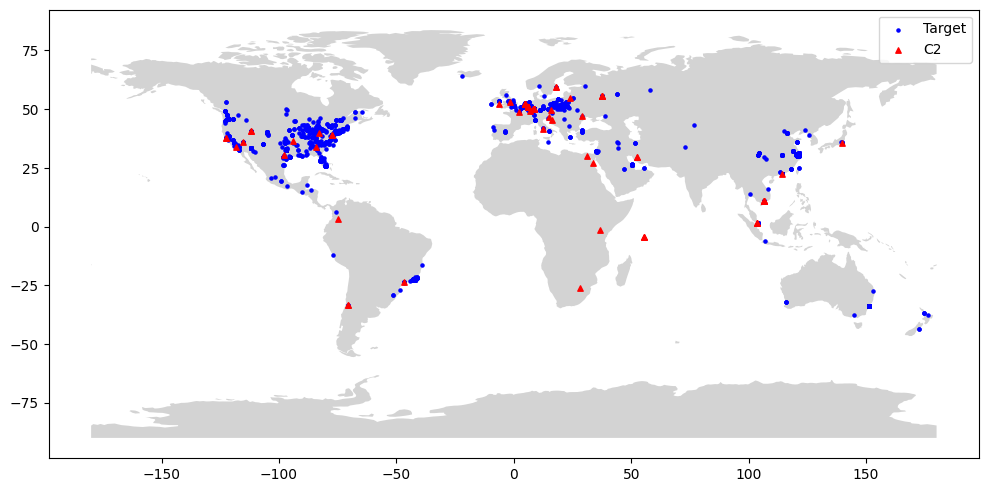

In [2]:
# geolocations
import geodatasets
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

base='extracted/combined'

targets = pd.read_csv(f'{base}/attack_info_enriched.csv')[['cnc_ip','t_loc','attack_type']]
targets = targets[(targets['attack_type'] != 'Scanning')]
targets['type'] = 'Target'
targets[['latitude','longitude']] = targets['t_loc'].str.split(',', expand=True)
targets['latitude'] = targets['latitude'].astype(float)
targets['longitude'] = targets['longitude'].astype(float)
targets.drop(columns=['t_loc'],inplace=True)
targets.drop(columns=['attack_type'],inplace=True)

c2s = pd.read_csv(f'{base}/cnc_info_enriched.csv')[['ip','port','loc']]
c2s = c2s.drop_duplicates()
print(f'---->{len(c2s)}')
c2s.rename(columns={'ip':'cnc_ip'},inplace=True)
c2s['type'] = 'C2'
c2s[['latitude','longitude']] = c2s['loc'].str.split(',', expand=True)
c2s['latitude'] = c2s['latitude'].astype(float)
c2s['longitude'] = c2s['longitude'].astype(float)
c2s.drop(columns=['loc','port'],inplace=True)

df = pd.concat([targets, c2s], ignore_index=True)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

color_map = {'Target': ['o','blue',5], 'C2': ['^','red',15]}
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color='lightgray')

for category, config in color_map.items():
    subset = gdf[gdf['type'] == category]
    subset.plot(ax=ax, marker=config[0], color=config[1], markersize=config[2], label=category)

plt.legend()
plt.savefig(f'{base}/geolocations.pdf', format='pdf')
plt.show()


44


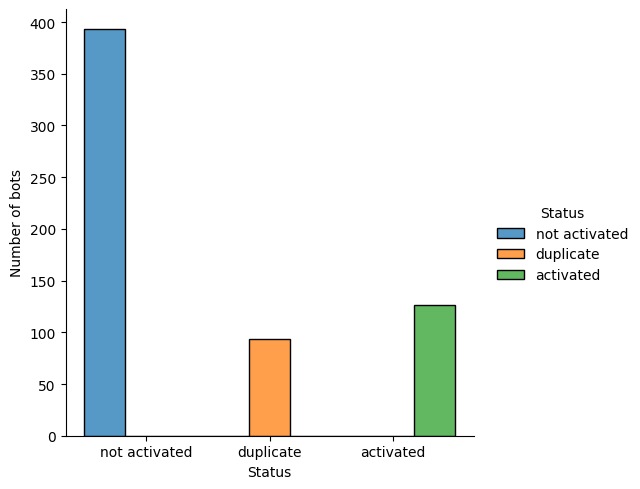

In [3]:
# bots
import seaborn as sns
import matplotlib.pyplot as plt

base='extracted/combined'
filter_s = datetime(2024, 6, 29, 00, 00, 00)
filter_e = datetime(2024, 7, 6, 00, 00, 00)
bots = pd.read_csv(f'{base}/bot_info.csv')
bots['observe_at'] = pd.to_datetime(bots['observe_at']).dt.tz_localize(None)
bots = bots[~((bots['observe_at'] > filter_s) & (bots['observe_at'] < filter_e))]
bots.query("status=='unstaged'").to_csv(f'{base}/bot_info_activated.csv')
#walker = pyg.walk(bots, kernel_computation=True)

def get_arch(row):
    if row['arch'] == 'MIPS' and row['endianness'] == 'L':
        return 'MIPSEL'
    else:
        return row['arch']

bots['Architecture'] = bots.apply(get_arch, axis=1)

def get_status(status):
    if status == 'error':
        return 'not activated'
    elif status == 'duplicate':
        return 'duplicate'
    else:
        return 'activated'
        
bots['Status'] = bots['status'].apply(get_status)

print(len(bots.query("family=='gafgyt' and status=='unstaged'")))
p = sns.displot(bots, x="Status", hue="Status", multiple="dodge", bins=['not activated','active', 'duplicate'])
p.set_axis_labels('Status', 'Number of bots')
plt.savefig(f'{base}/bots-status.pdf', format='pdf')

     bot_id        measure_start          measure_end  duration version  \
0  87cb7390  2024-06-17 11:55:14  2024-06-17 12:21:53  0.444167      v1   
1  87cb7390  2024-06-17 12:23:30  2024-06-17 15:53:26  3.498889      v1   
2  87cb7390  2024-06-18 09:55:03  2024-06-18 12:52:47  2.962222      v1   
3  87cb7390  2024-06-18 15:32:07  2024-06-18 15:41:59  0.164444      v1   
4  87cb7390  2024-06-18 15:46:04  2024-06-18 18:13:55  2.464167      v1   

                 time  
0 2024-06-17 11:55:14  
1 2024-06-17 12:23:30  
2 2024-06-18 09:55:03  
3 2024-06-18 15:32:07  
4 2024-06-18 15:46:04  
     bot_id        Date
0  87cb7390  2024-06-17
2  87cb7390  2024-06-18
5  87cb7390  2024-06-19
6  87cb7390  2024-06-20
8  87cb7390  2024-06-21


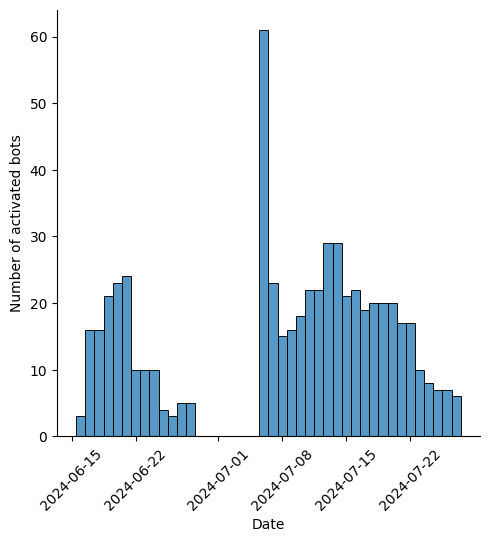

In [367]:
# measurements
import seaborn as sns
import matplotlib.pyplot as plt

base='extracted/combined'
filter_s = datetime(2024, 6, 29, 00, 00, 00)
filter_e = datetime(2024, 7, 6, 00, 00, 00)
ms = pd.read_csv(f'{base}/measurements.csv')
ms.drop(columns=['Unnamed: 0'],inplace=True)
ms['time'] = pd.to_datetime(ms['measure_start'])
print(ms.head())
ms = ms[~((ms['time'] > filter_s) & (ms['time'] < filter_e))]
ms['Date'] = pd.to_datetime(ms['time']).dt.date

ab = pd.read_csv(f'{base}/bot_info_activated.csv')['bot_id'].unique()
ab = [b[:8] for b in ab]

ms = ms[(ms['bot_id'].isin(ab))]

mss = ms[['bot_id', 'Date']]
#walker = pyg.walk(mss, kernel_computation=True)
mss = mss.drop_duplicates()
# outlier of 2024-07-06 due to unstaged bots mannually to select active bots, active bots are rougly 15 as i remember
print(mss.head())
#walker = pyg.walk(mss, kernel_computation=True)

p = sns.displot(mss, x="Date", multiple="dodge")
p.set_axis_labels('Date', 'Number of activated bots')
plt.xticks(rotation=45)
plt.savefig(f'{base}/measurements.pdf', format='pdf')


{'Hardcoded IP': 46, 'pty.su': 8, 'raw.kovey-net.ru': 2, 'raw.theeye.cc': 1, 'bot.abcproxy.click': 3, 'seyfhg.work.gd': 1, 'botnet.91av.live': 1, 'clients.kaitenc2.de': 1, 'boats.cloudboats.vip': 1, 'www.botnet123.cc': 1, 'meowware.ddns.net': 1, 'f.codingdrunk.cc': 1, 'srobinhan.com': 1, 'br.suicide2024.xyz': 1, 'vnm-sro.com': 1, 'eaefae.savirland.com': 1, '_spf.staffingglobal.in': 1, 'srouocmo.net': 1, 'c.cnc.gay': 1}


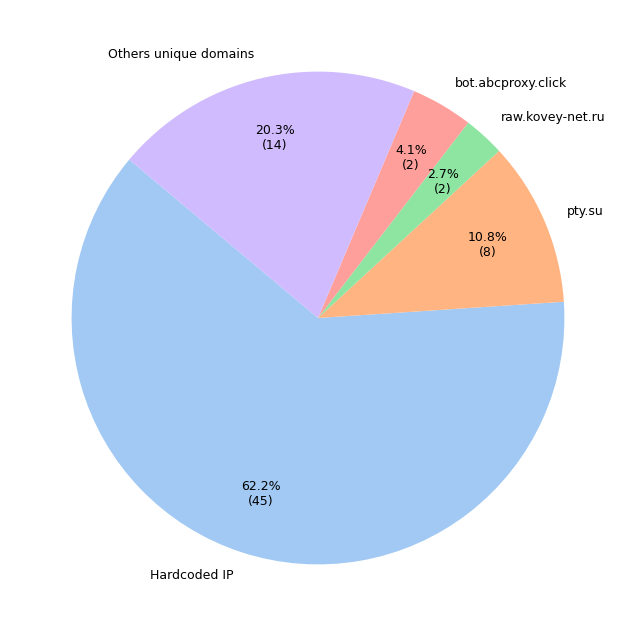

In [462]:
# c2 domains
import geodatasets
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

base='extracted/combined'

c2s = pd.read_csv(f'{base}/cnc_info_enriched.csv')[['ip','domain']]
c2s = c2s.drop_duplicates()

def rectify_domain(domain):
    if pd.isna(domain):
        return 'Hardcoded IP'
    else:
        return domain
c2s['Domain'] = c2s['domain'].apply(rectify_domain)

dd = {}
labels = []
sizes = []
for row in c2s.itertuples():
    if row.Domain not in dd:
        dd[row.Domain] = 1
    else:
        dd[row.Domain] += 1
    
print(f'{dd}')
key_del = []
dd['Others unique domains'] = 0
for k, v in dd.items():
    if v == 1:
        key_del.append(k)
        dd['Others unique domains'] += 1

for k in key_del:
    del dd[k]

for k, v in dd.items():
    labels.append(k)
    sizes.append(v)

colors = sns.color_palette('pastel')
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct=lambda pct: func(pct, sizes),
    startangle=140, 
    textprops={'fontsize': 9}, 
    pctdistance=0.75,
    #labeldistance=1
)

for text in texts:
   # print(f'{text.get_text()}')
    if text.get_text() in ['f.codingdrunk.cc','clients.kaitenc2.de','bot.abcproxy.click','raw.kovey-net.ru','Others unique domains']:
        text.set_rotation(0)

for autotext in autotexts:
    autotext.set_rotation(0)

#plt.title('C2 Domains')
plt.savefig(f'{base}/c2-domain.pdf', format='pdf')
plt.show()

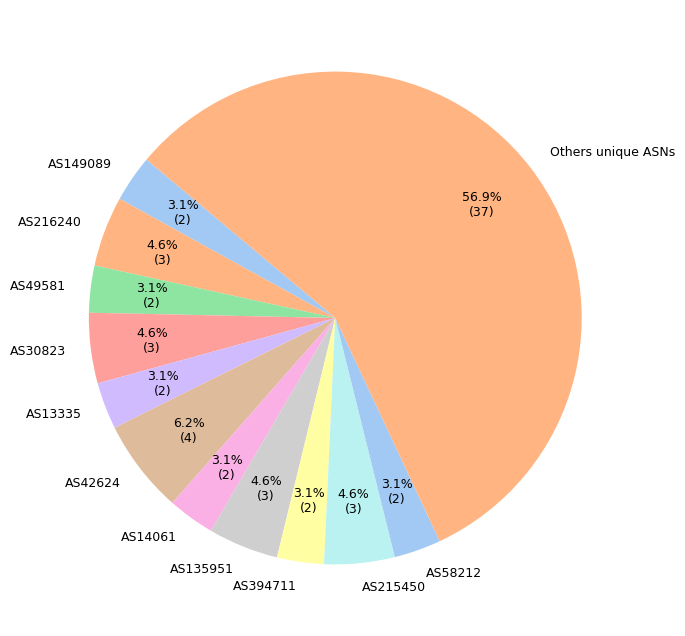

In [466]:
#c2 asn

base='extracted/combined'

asns = pd.read_csv(f'{base}/cnc_info_enriched.csv')[['ip','org']]
asns = asns.drop_duplicates()
asns[['ASN','Orgnization']] = asns['org'].str.split(' ', n=1, expand=True)
asns = asns[~(asns['org'].isna())]
#print(c2s.head())

dd = {}
labels = []
sizes = []
for row in asns.itertuples():
    if row.ASN not in dd:
        dd[row.ASN] = 1
    else:
        dd[row.ASN] += 1
    
#print(f'{dd}')
key_del = []
dd['Others unique ASNs'] = 0
for k, v in dd.items():
    if v == 1:
        key_del.append(k)
        dd['Others unique ASNs'] += 1

for k in key_del:
    del dd[k]

for k, v in dd.items():
    labels.append(k)
    sizes.append(v)

colors = sns.color_palette('pastel')
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct=lambda pct: func(pct, sizes),
    startangle=140, 
    textprops={'fontsize': 9}, 
    pctdistance=0.75,
    #labeldistance=1
)

for text in texts:
   # print(f'{text.get_text()}')
    if text.get_text() in ['f.codingdrunk.cc','clients.kaitenc2.de','bot.abcproxy.click','raw.kovey-net.ru','Others unique domains']:
        text.set_rotation(0)

for autotext in autotexts:
    autotext.set_rotation(0)

#plt.title('C2 Domains')
plt.savefig(f'{base}/c2-asns.pdf', format='pdf')
plt.show()


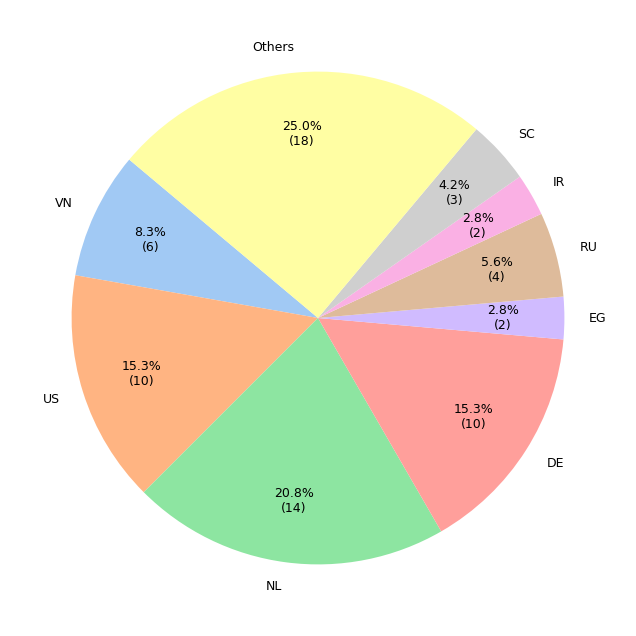

In [467]:
#c2 countries

base='extracted/combined'

countries = pd.read_csv(f'{base}/cnc_info_enriched.csv')[['ip','country']]
countries = countries.drop_duplicates()
countries = countries[~(countries['country'].isna())]
#print(c2s.head())

dd = {}
labels = []
sizes = []
for row in countries.itertuples():
    if row.country not in dd:
        dd[row.country] = 1
    else:
        dd[row.country] += 1
    
#print(f'{dd}')
key_del = []
dd['Others'] = 0
for k, v in dd.items():
    if v == 1:
        key_del.append(k)
        dd['Others'] += 1

for k in key_del:
    del dd[k]

for k, v in dd.items():
    labels.append(k)
    sizes.append(v)

colors = sns.color_palette('pastel')
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct=lambda pct: func(pct, sizes),
    startangle=140, 
    textprops={'fontsize': 9}, 
    pctdistance=0.75,
    #labeldistance=1
)

for text in texts:
   # print(f'{text.get_text()}')
    if text.get_text() in ['f.codingdrunk.cc','clients.kaitenc2.de','bot.abcproxy.click','raw.kovey-net.ru','Others unique domains']:
        text.set_rotation(0)

for autotext in autotexts:
    autotext.set_rotation(0)

#plt.title('C2 Domains')
plt.savefig(f'{base}/c2-countries.pdf', format='pdf')
plt.show()


                      C2        Date
9     94.156.10.24:33335  2024-06-17
12    94.156.10.24:33335  2024-06-18
15    94.156.10.24:33335  2024-06-19
16  152.89.244.142:33335  2024-06-20
19  152.89.244.142:33335  2024-06-21
81
                     C2  Days
0   103.162.20.166:3007     7
1   103.162.20.199:3007     2
2     103.162.20.199:80     2
3    103.162.20.69:3007    10
4  103.167.88.191:43957     5


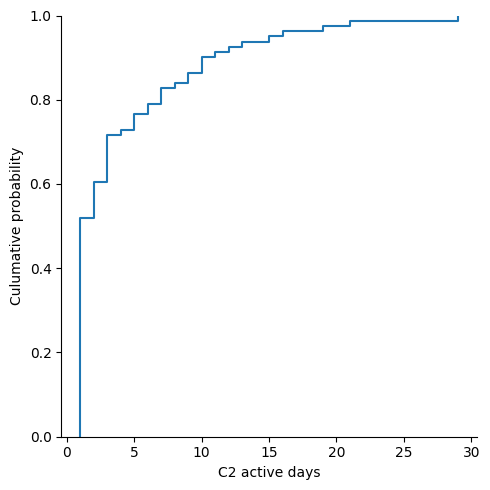

In [504]:
#c2 hong many days does a cnc exists.

base='extracted/combined'

c2stats = pd.read_csv(f'{base}/cnc-stats.csv')
c2stats = c2stats[((c2stats['is_cnc'] == True) & (c2stats['total_bytes'] > 0))]
c2stats = c2stats[['ip','port','measure_start']]
c2stats['C2'] = c2stats['ip'] + ':' + c2stats['port'].astype(str)
c2stats['Date'] = pd.to_datetime(c2stats['measure_start']).dt.date
c2stats.drop(columns=['measure_start','ip','port'],inplace=True)
c2stats.drop_duplicates(inplace=True)
print(c2stats.head())
print(f'{len(c2stats['C2'].unique())}')  # TODO: c2 info should be filtered against this list

result = c2stats.groupby('C2')['Date'].nunique().reset_index()
result.columns = ['C2', 'Days']
print(result.head())

p = sns.displot(result, x="Days", kind="ecdf")
p.set_axis_labels('C2 active days', 'Culumative probability')
plt.xticks(rotation=0)
plt.savefig(f'{base}/c2-days.pdf', format='pdf')


0


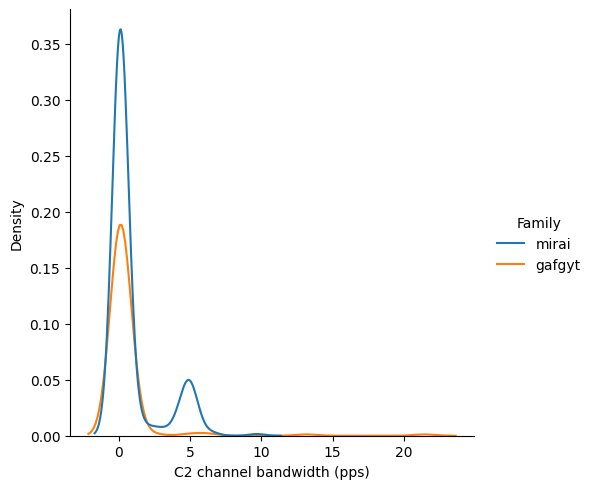

In [548]:
#c2 what is the bandwidth of a c2 channel

base='extracted/combined'

bots = pd.read_csv(f'{base}/bot_info.csv')[['bot_id','family','status']]
bots['bot_id'] = bots['bot_id'].str[:8]

bd = {}
for b in bots.itertuples():
    if b.status == 'unstaged':
        bd[b.bot_id] = b.family

#print(bots.head())

def get_family(bid):
    if bid in bd:
        return bd[bid]
    else:
        return 'NA'

c2stats = pd.read_csv(f'{base}/cnc-stats.csv')
c2stats = c2stats[((c2stats['is_cnc'] == True) & (c2stats['total_bytes'] > 0))]
c2stats = c2stats[['ip','port','duration','packet_cnt','bot_id']]
c2stats['pps'] = c2stats['packet_cnt'] / c2stats['duration']
c2stats['Family'] = c2stats['bot_id'].apply(get_family)

#print(c2stats.query('pps>5').head())
print(len(c2stats.query('pps>100')))

p = sns.displot(c2stats, x='pps',hue='Family', kind='kde')
p.set_axis_labels('C2 channel bandwidth (pps)', 'Density')
plt.xticks(rotation=0)
plt.savefig(f'{base}/c2-bandwidth.pdf', format='pdf')

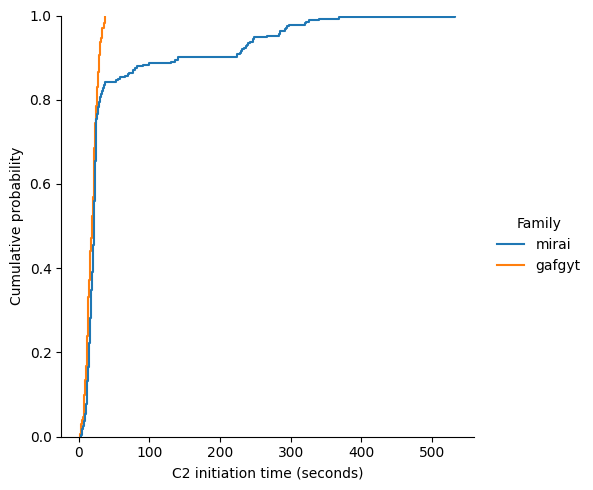

In [865]:
#c2 when did bot initialize C2 connection?

base='extracted/combined'

bots = pd.read_csv(f'{base}/bot_info.csv')[['bot_id','family','status']]
bots['bot_id'] = bots['bot_id'].str[:8]

bd = {}
for b in bots.itertuples():
    if b.status == 'unstaged':
        bd[b.bot_id] = b.family

#print(bots.head())

def get_family(bid):
    if bid in bd:
        return bd[bid]
    else:
        return 'NA'

c2stats = pd.read_csv(f'{base}/cnc-stats.csv')
c2stats = c2stats[((c2stats['is_cnc'] == True) & (c2stats['total_bytes'] > 0))]

#c2stats = c2stats[['attemp_start','bot_id']]
c2stats['attempt_start'] = pd.to_timedelta(c2stats['attemp_start'])
c2stats['seconds'] = c2stats['attempt_start'].apply(lambda x: x.total_seconds())
c2stats['Family'] = c2stats['bot_id'].apply(get_family)

#print(c2stats.query('seconds>180'))

p = sns.displot(c2stats.query('seconds < 1200'), x='seconds',hue='Family', kind='ecdf')
p.set_axis_labels('C2 initiation time (seconds)', 'Cumulative probability')
plt.xticks(rotation=0)
plt.savefig(f'{base}/c2-initiation.pdf', format='pdf')

      Unnamed: 0              ip   port is_new  packet_cnt  total_bytes  \
97            97  212.102.40.182     22    yes           4         2720   
102          102   103.105.23.65   3306    yes           4         2720   
103          103   110.173.63.10   3306    yes           3         2040   
104          104   172.65.41.112   3306    yes           4         2720   
446          446  142.250.74.228    443     no          18           18   
805          805  45.128.232.139  33335    NaN         345          751   
924          924   23.237.71.242     80    NaN          86           90   
929          929   209.141.35.56  36508    NaN         524          212   
1068        1068     82.13.22.75     80    NaN         192          360   

      syn_cnt  fin_cnt  rst_cnt                  start_time  ...  \
97          4        0        0  2024-06-23 14:01:49.414922  ...   
102         4        0        0  2024-06-24 19:51:05.367035  ...   
103         3        0        0  2024-06-24 1

/tmp/ipykernel_21282/3965936798.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_21282/3965936798.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


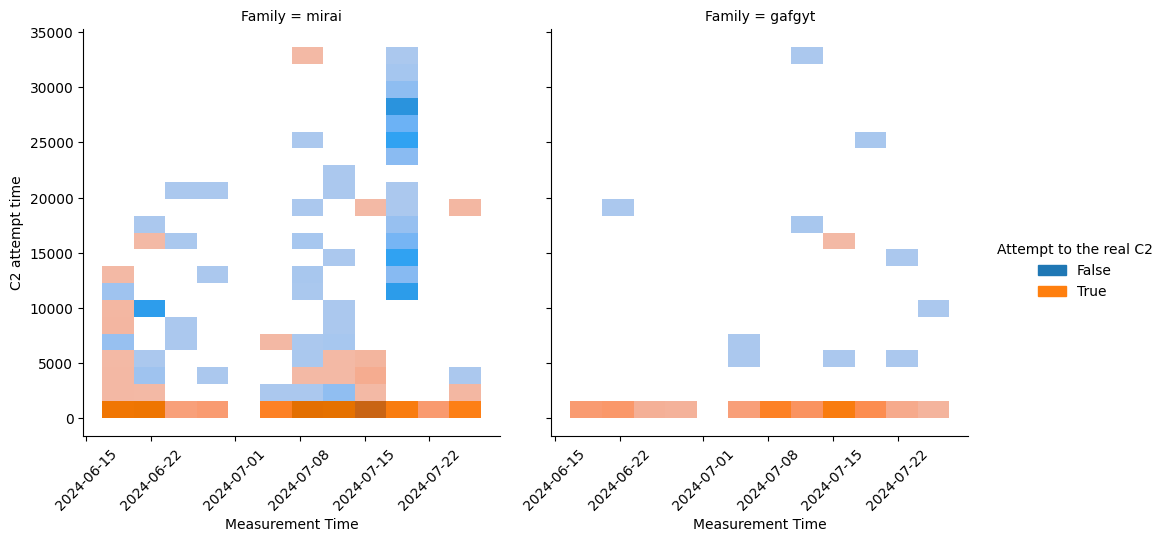

In [874]:
#c2 How C2 attempts are made by bots

base='extracted/combined'

bots = pd.read_csv(f'{base}/bot_info.csv')[['bot_id','family','status']]
bots['bot_id'] = bots['bot_id'].str[:8]

bd = {}
for b in bots.itertuples():
    if b.status == 'unstaged':
        bd[b.bot_id] = b.family

#print(bots.head())

def get_family(bid):
    if bid in bd:
        return bd[bid]
    else:
        return 'NA'

c2stats = pd.read_csv(f'{base}/cnc-stats.csv')
#c2stats = c2stats[((c2stats['is_cnc'] == True) & (c2stats['total_bytes'] > 0))]
#c2stats = c2stats[['attemp_start','bot_id']]
c2stats['attempt_start'] = pd.to_timedelta(c2stats['attemp_start'])
c2stats['Time'] = pd.to_datetime(c2stats['measure_start'])
c2stats['seconds'] = c2stats['attempt_start'].apply(lambda x: x.total_seconds())
c2stats['Family'] = c2stats['bot_id'].apply(get_family)
#c2stats['Confirmed as C2'] = c2stats['is_cnc'].apply(lambda x: 'Yes' if x else 'No')
c2stats.rename(columns={'is_cnc':'Attempt to the real C2'}, inplace=True)


print(c2stats.query('seconds>15000 and total_bytes > 0'))

p = sns.displot(data=c2stats.query('Family != "NA"'), x="Time", y="seconds", hue="Attempt to the real C2", col='Family')
p.set_axis_labels('Measurement Time', 'C2 attempt time')
for ax in p.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#ax = plt.gca()
#ax.set_xticklabels('')
plt.savefig(f'{base}/c2-attempts.pdf', format='pdf')


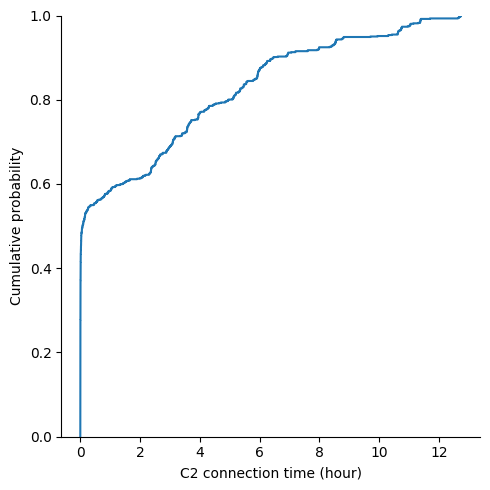

In [701]:
#c2 C2 connection durations

base='extracted/combined'

#c2status = pd.read_csv(f'{base}/cnc-status.csv')
#c2status['measure_start'] = pd.to_datetime(c2status['measure_start'])
#c2status['measure_end'] = pd.to_datetime(c2status['measure_end'])
#c2status['update_time'] = pd.to_datetime(c2status['update_time'])
#
#curr = None
#conn = []
#th = 30
#for row in c2status.itertuples():
#    if row.status == 'alive':
#        # submit for previous manually disconnected connection first
#        if curr is not None:
#            if curr[7] > th:
#                conn.append(curr)
#        curr = [row.measure_start, row.bot_id, row.ip, row.port, row.update_time, row.measure_end, 'by tool']
#        curr.append((curr[5] - curr[4]).total_seconds())
#    elif row.status == 'disconnected':
#        if curr is None:
#            print(f'curr is None, should not happen {row}')
#        else:
#            if curr[1] != row.bot_id or curr[2] != row.ip or curr[3] != row.port or curr[0] != row.measure_start:
#                print(f'Not closed connection, should not happen {row}')
#            else:
#                # update disconnection time
#                curr[5] = row.update_time
#                curr[6] = 'by bot'
#                curr[7] = (curr[5] - curr[4]).total_seconds()
#                if curr[7] > th:
#                    conn.append(curr)
#                curr = None
#    else:
#        pass
#        #print(f'skip invalid status, {row}')
#
#df = pd.DataFrame(conn, columns=['measure_start','bot_id', 'ip', 'port', 'start_time', 'end_time', 'disconnected_by', 'duration'])
#df.to_csv(f'{base}/c2-connections.csv', index = False)
#print(df.head())

df = pd.read_csv(f'{base}/c2-connections.csv')
df = df.query("ip != '31.31.233.28'")
df = df[~((df['disconnected_by'] == 'by tool') & (df['duration'] < 7200))]
df.to_csv(f'{base}/c2-connections_filtered.csv')
df['duration'] = df['duration'] / 3600
#print(df.query('duration < 180'))

p = sns.displot(df, x='duration', kind='ecdf')
p.set_axis_labels('C2 connection time (hour)', 'Cumulative probability')
plt.xticks(rotation=0)
plt.savefig(f'{base}/c2-connection-duration.pdf', format='pdf')
    


  t_country
0        DE
1        DE
2        FR
3        US
4        GB


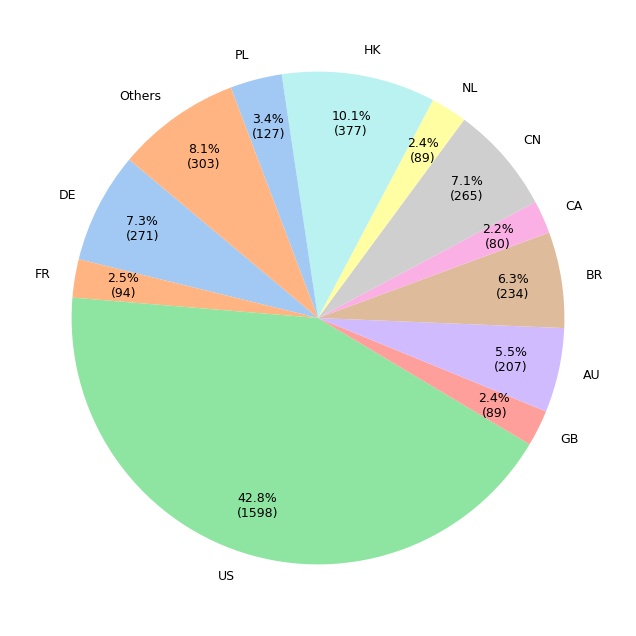

In [769]:
# attacked countries
#c2 countries

base='extracted/combined'

countries = pd.read_csv(f'{base}/attack_info_enriched.csv')
countries = countries[~(countries['attack_type'] == 'Scanning')]
countries = countries[['t_country']]
countries = countries[~(countries['t_country'].isna())]
print(countries.head())

dd = {}
labels = []
sizes = []
for row in countries.itertuples():
    if row.t_country not in dd:
        dd[row.t_country] = 1
    else:
        dd[row.t_country] += 1
    
#print(f'{dd}')
key_del = []
dd['Others'] = 0
for k, v in dd.items():
    if v < 50:
        key_del.append(k)
        dd['Others'] += v

for k in key_del:
    del dd[k]

for k, v in dd.items():
    labels.append(k)
    sizes.append(v)

colors = sns.color_palette('pastel')
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct=lambda pct: func(pct, sizes),
    startangle=140, 
    textprops={'fontsize': 9}, 
    pctdistance=0.8,
    #labeldistance=1
)

for text in texts:
   # print(f'{text.get_text()}')
    if text.get_text() in ['f.codingdrunk.cc','clients.kaitenc2.de','bot.abcproxy.click','raw.kovey-net.ru','Others unique domains']:
        text.set_rotation(0)

for autotext in autotexts:
    autotext.set_rotation(0)

#plt.title('C2 Domains')
plt.savefig(f'{base}/attack-countries.pdf', format='pdf')
plt.show()

                               t_org      ASN                Orgnization
0           AS60068 Datacamp Limited  AS60068           Datacamp Limited
1           AS60068 Datacamp Limited  AS60068           Datacamp Limited
2  AS20473 The Constant Company, LLC  AS20473  The Constant Company, LLC
3                    AS16276 OVH SAS  AS16276                    OVH SAS
4               AS13213 UK-2 Limited  AS13213               UK-2 Limited


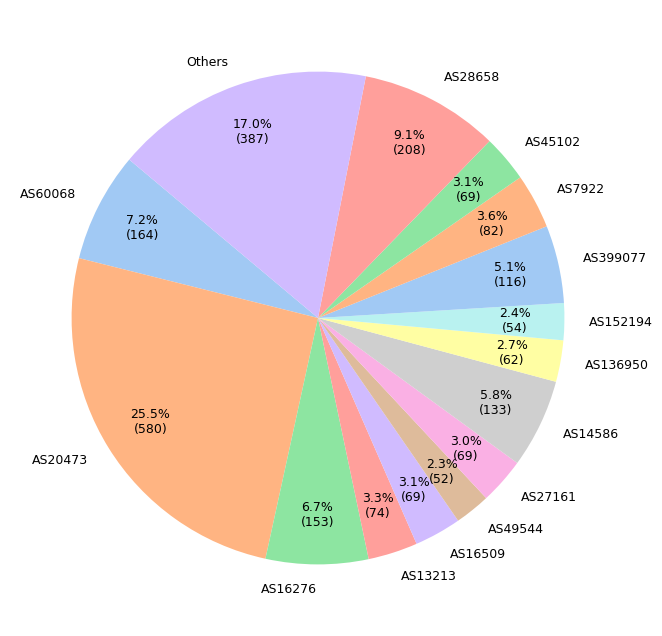

In [770]:
# attacked ASNs

base='extracted/combined'

asns = pd.read_csv(f'{base}/attack_info_enriched.csv')
asns = asns[~(asns['attack_type'] == 'Scanning')]
asns = asns[['t_org']]
asns = asns[~(asns['t_org'].isna())]
asns[['ASN','Orgnization']] = asns['t_org'].str.split(' ', n=1, expand=True)
print(asns.head())

dd = {}
labels = []
sizes = []
for row in asns.itertuples():
    if row.ASN not in dd:
        dd[row.ASN] = 1
    else:
        dd[row.ASN] += 1
    
#print(f'{dd}')
key_del = []
dd['Others'] = 0
for k, v in dd.items():
    if v < 50:
        key_del.append(k)
        dd['Others'] += 1

for k in key_del:
    del dd[k]

for k, v in dd.items():
    labels.append(k)
    sizes.append(v)

colors = sns.color_palette('pastel')
def func(pct, allvalues):
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    colors=colors, 
    autopct=lambda pct: func(pct, sizes),
    startangle=140, 
    textprops={'fontsize': 9}, 
    pctdistance=0.8,
    #labeldistance=1
)

for text in texts:
   # print(f'{text.get_text()}')
    if text.get_text() in ['f.codingdrunk.cc','clients.kaitenc2.de','bot.abcproxy.click','raw.kovey-net.ru','Others unique domains']:
        text.set_rotation(0)

for autotext in autotexts:
    autotext.set_rotation(0)

#plt.title('C2 Domains')
plt.savefig(f'{base}/attack-asns.pdf', format='pdf')
plt.show()

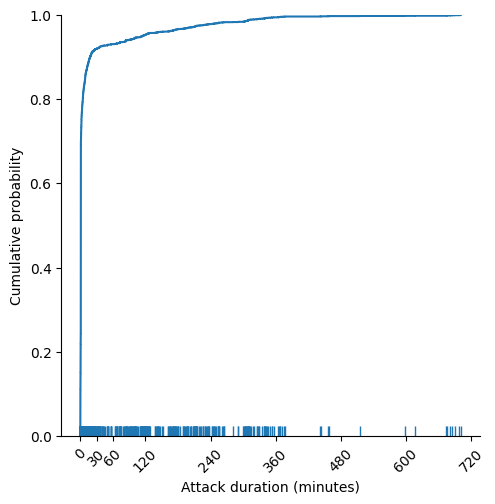

In [771]:
# attack duration

base='extracted/combined'

attacks = pd.read_csv(f'{base}/attack_info_enriched.csv')
attacks = attacks[~(attacks['attack_type'] == 'Scanning')]
attacks['duration'] = pd.to_timedelta(attacks['duration']).dt.total_seconds() / 60
#print(attacks.query('duration > 600'))

p = sns.displot(attacks, x='duration', kind='ecdf', rug=True)
p.set_axis_labels('Attack duration (minutes)', 'Cumulative probability')
plt.xticks([0,30,60,120,240,360,480,600,720],rotation=45)
plt.savefig(f'{base}/attack-duration.pdf', format='pdf')
    

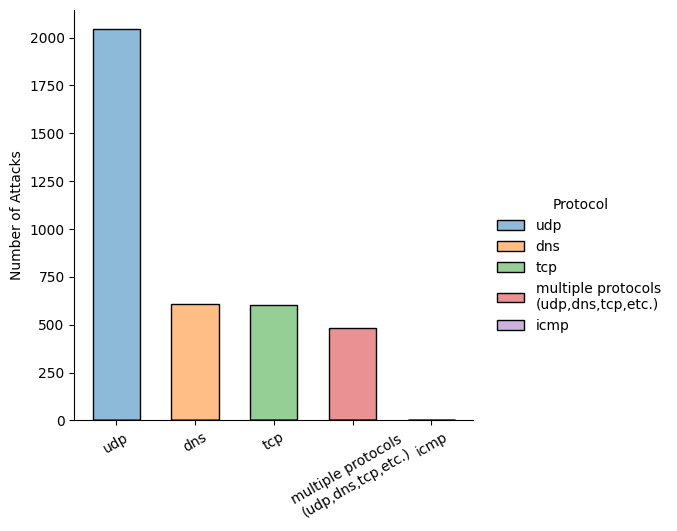

In [815]:
# attack layers

base='extracted/combined'

attacks = pd.read_csv(f'{base}/attack_info_enriched.csv')
attacks = attacks[~(attacks['attack_type'] == 'Scanning')]
attacks['Protocol'] = attacks['protocol'].apply(lambda x: 'multiple protocols \n(udp,dns,tcp,etc.)' if x.find(',') > 0 else x)

protocol_counts = attacks['Protocol'].value_counts().reset_index()
protocol_counts.columns = ['Protocol', 'Count']
protocol_counts = protocol_counts.sort_values(by='Count', ascending=False)
attacks['Protocol'] = pd.Categorical(attacks['Protocol'], categories=protocol_counts['Protocol'], ordered=True)

p = sns.displot(attacks, x='Protocol', hue='Protocol', shrink=.6)
p.set_axis_labels('', 'Number of Attacks')
plt.xticks(rotation=30)
plt.savefig(f'{base}/attack-layers.pdf', format='pdf')
plt.show()


#p = sns.displot(attacks, x='Protocol', hue='Protocol', shrink=.6, order=protocol_order)
#p.set_axis_labels('Protocols', 'Number of attacks')
##plt.xticks(['udp','dns','tcp','multiple protocols','icmp'],rotation=45)
#plt.savefig(f'{base}/attack-layers.pdf', format='pdf')

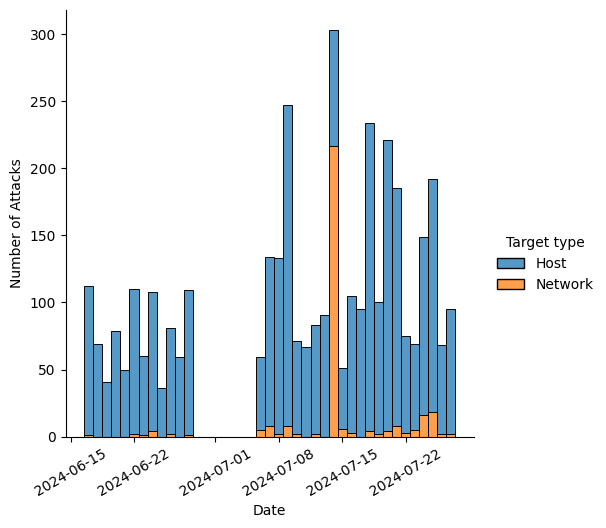

In [821]:
# attack number per day

base='extracted/combined'

attacks = pd.read_csv(f'{base}/attack_info_enriched.csv')
attacks = attacks[~(attacks['attack_type'] == 'Scanning')]
attacks['Date'] = pd.to_datetime(attacks['time']).dt.date
attacks['Target type'] = attacks['target'].apply(lambda x: 'Network' if x.find('/24') > 0 else 'Host')

p = sns.displot(attacks, x='Date', hue='Target type', multiple='stack')
p.set_axis_labels('Date', 'Number of Attacks')
plt.xticks(rotation=30)
plt.savefig(f'{base}/attack-per-day.pdf', format='pdf')
plt.show()

           cnc_ip  Count
0  185.150.26.211    853
1   45.95.169.138    654
2  152.89.244.142    346
3  152.89.244.251    340
4  45.128.232.243    289
5  45.128.232.190    256
6  45.128.232.139    252
7    92.249.48.54    202
8  152.89.246.204     73
9    94.156.10.24     65


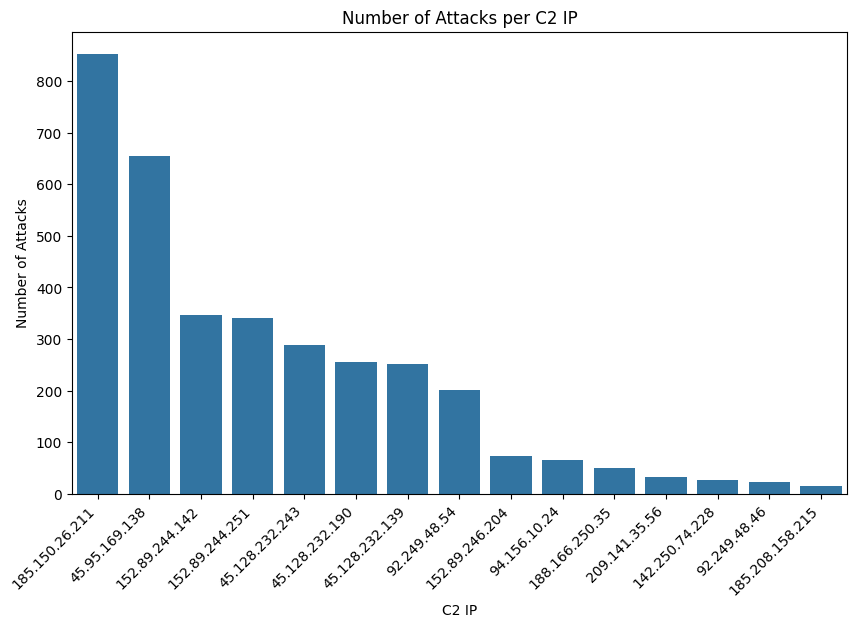

In [812]:
# attack number per C2

base='extracted/combined'

attacks = pd.read_csv(f'{base}/attack_info_enriched.csv')
attacks = attacks[~(attacks['attack_type'] == 'Scanning')]

#c2_counts = attacks['cnc_ip'].value_counts().reset_index()
#c2_counts.columns = ['cnc_ip', 'Count']
#c2_counts = c2_counts.sort_values(by='Count', ascending=False)
#c2_counts['cnc_ip'] = c2_counts.apply(lambda x: x['cnc_ip'] if x['Count'] >= 5 else 'Others', axis=1)
#
#attacks['cnc_ip'] = attacks['cnc_ip'].apply(lambda x: x if x in c2_counts['cnc_ip'].values else 'Others')

c2_counts = attacks['cnc_ip'].value_counts().reset_index()
c2_counts.columns = ['cnc_ip', 'Count']
c2_counts = c2_counts.sort_values(by='Count', ascending=False)
print(c2_counts.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='cnc_ip', y='Count', data=c2_counts.head(15))
plt.xlabel('C2 IP')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks per C2 IP')
plt.xticks(rotation=45, ha='right')
plt.savefig(f'{base}/attack-per-c2.pdf', format='pdf')
plt.show()

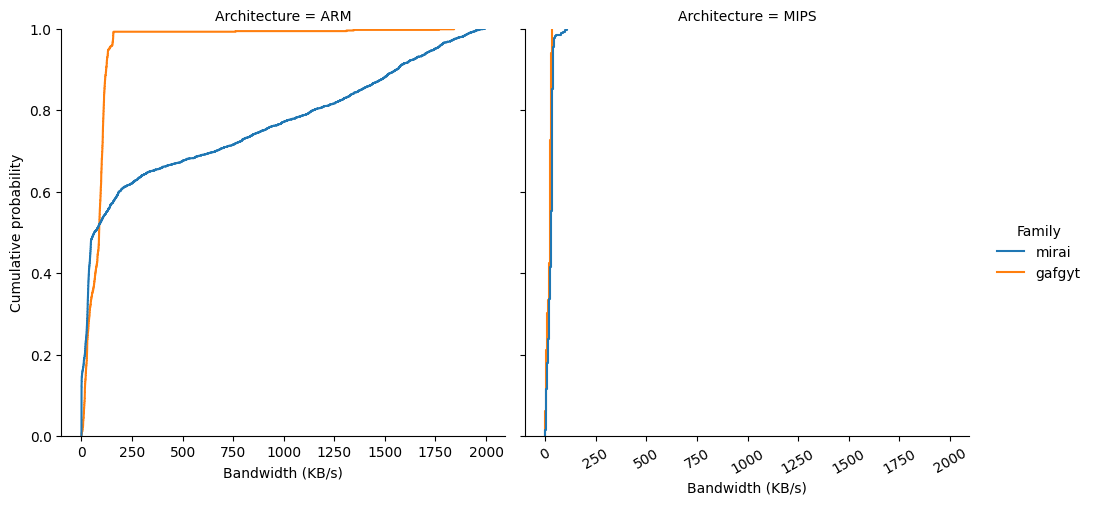

In [863]:
# attack bandwidth

base='extracted/combined'

bots = pd.read_csv(f'{base}/bot_info.csv')[['bot_id','family','arch','status']]
#bots['bot_id'] = bots['bot_id'].str[:8]

bf = {}
ba = {}
for b in bots.itertuples():
    if b.status != 'error':
        bf[b.bot_id] = b.family
        ba[b.bot_id] = b.arch

attacks = pd.read_csv(f'{base}/attack_info_enriched.csv')
attacks = attacks[~(attacks['attack_type'] == 'Scanning')]
attacks['Family'] = attacks['bot_id'].apply(lambda x: bf[x] if x in bf else 'NA')
attacks['Architecture'] = attacks['bot_id'].apply(lambda x: ba[x] if x in ba else 'NA')
attacks['Bandwidth'] = attacks['bandwidth'] / 1024

p = sns.displot(attacks.query('Family!="NA" and Bandwidth < 2000'), x='Bandwidth', hue='Family', col='Architecture', kind='ecdf')
p.set_axis_labels('Bandwidth (KB/s)', 'Cumulative probability')
plt.xticks(rotation=30)
plt.savefig(f'{base}/attack-bandwidth.pdf', format='pdf')
plt.show()

       Port  Count
11    37215     97
14     2323     24
15       23     24
13      443     24
12       80     24
22     8081     17
18    52869     17
1081   6466     10
5     15987      7
1     54123      6


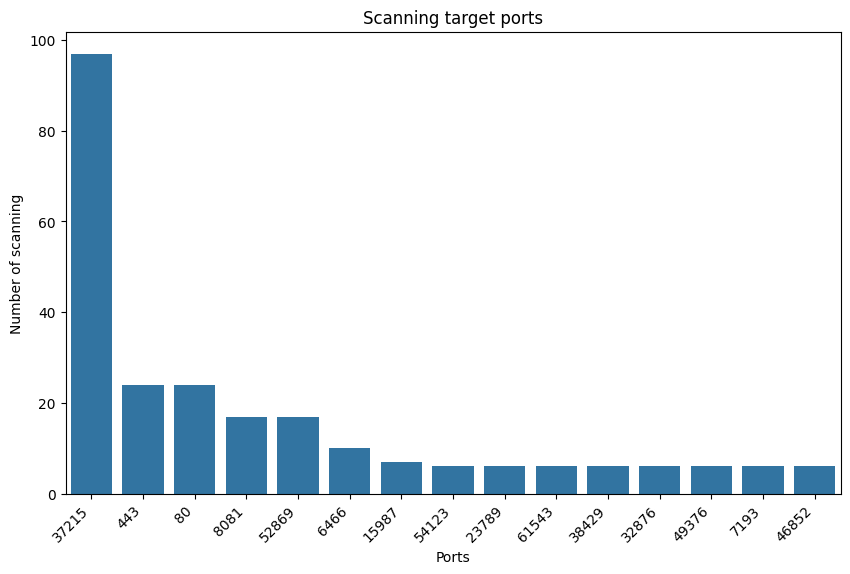

In [860]:
# scanning

base='extracted/combined'

attacks = pd.read_csv(f'{base}/attack_info_enriched.csv')
scans = attacks[(attacks['attack_type'] == 'Scanning')]
scans.to_csv(f'{base}/scanning.csv')

port_dict = {}
for row in scans.itertuples():
    ps = row.dst_port.split(',')
    for p in ps:
        if p not in port_dict:
            port_dict[p] = 1
        else:
            port_dict[p] += 1



ls = []
for k, v in port_dict.items():
    ls.append([k, v])

ports = pd.DataFrame(ls, columns=['Port', 'Count'])
ports = ports.sort_values(by='Count', ascending=False)
print(ports.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Port', y='Count', data=ports.query('Port != "23" and Port != "2323"').head(15))
plt.xlabel('Ports')
plt.ylabel('Number of scanning')
plt.title('Scanning target ports')
plt.xticks(rotation=45, ha='right')
plt.savefig(f'{base}/scanning-ports.pdf', format='pdf')
plt.show()

         key  Count
0    SIGSEGV    318
1    SIGKILL    240
2     SIGILL    236
3    SIGPIPE     12
4  ETIMEDOUT      6


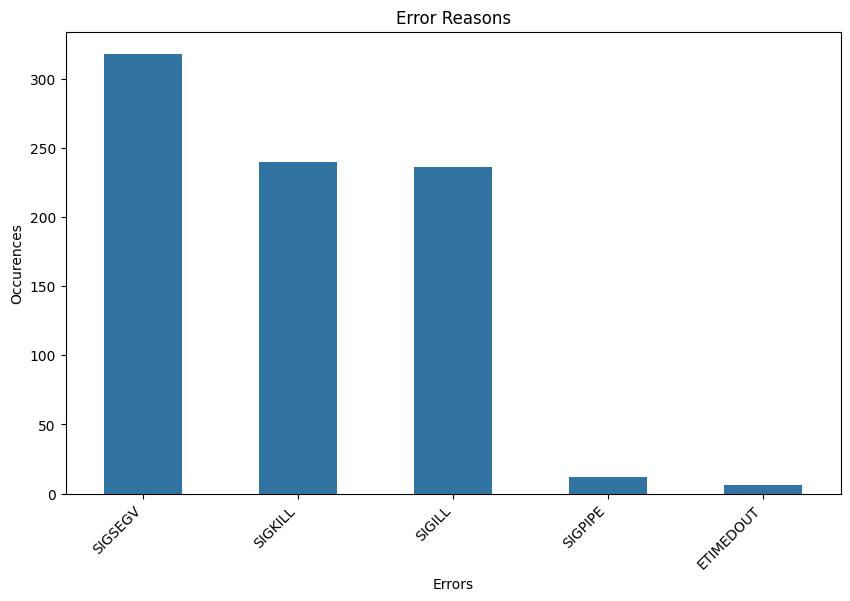

In [11]:
# error analysis
base='extracted/combined'

#errors = pd.read_csv(f'{base}/error.csv')[['key']]
#errors = errors[~((errors['key'] == 'ENOENT') | (errors['key'] == 'exit'))].to_csv(f'{base}/error_keys.csv', index=False)

errors = pd.read_csv(f'{base}/error_keys.csv')
err_counts = errors['key'].value_counts().reset_index()
err_counts.columns = ['key', 'Count']
err_counts = err_counts.sort_values(by='Count', ascending=False)
print(err_counts.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='key', y='Count', data=err_counts, width=0.5)
plt.xlabel('Errors')
plt.ylabel('Occurences')
plt.title('Error Reasons')
plt.xticks(rotation=45, ha='right')
plt.savefig(f'{base}/error-reason.pdf', format='pdf')
plt.show()


773


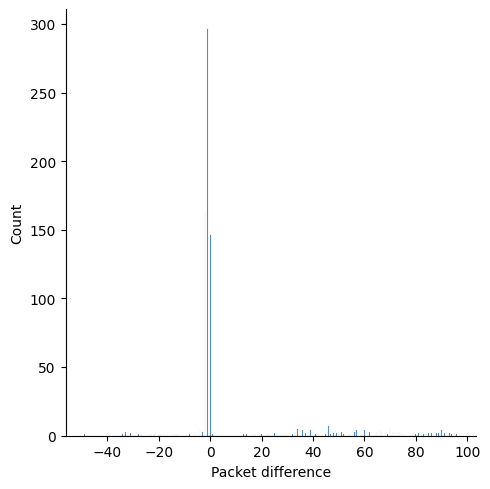

In [28]:
# attack detection 

base='extracted/combined'

df = pd.read_csv(f'{base}/attack_info_enriched.csv')
df = df[~((df['version'] == 'v2') | (df['packet_cnt_check'] == -1))]
#df = df[['packet_cnt_check','packet_num']]
df['packet_diff'] = df['packet_cnt_check'] - df['packet_num']
# this outlier has been confimred as due to filter difference: e.g.,retransimission packets are counted or not, tcp.len==0 is counted or not
# so we just remove these noises from the analysis
df = df[~((df['packet_diff'] < -100) | (df['packet_diff'] > 100))] 
df.to_csv(f'{base}/detection_error.csv')
print(f'{len(df)}')

p = sns.displot(df, x='packet_diff')
p.set_axis_labels('Packet difference', 'Count')
#plt.xticks(rotation=30)
#plt.show()
#plt.savefig(f'{base}/detection-error.pdf', format='pdf')
